In [1]:
## Uncomment and run cell to compile the NEURON mod files (Linux)
# !nrnivmodl

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import os
import seaborn as sns
from datetime import datetime

import pickle
import torch
import multiprocessing
from tqdm.notebook import trange, tqdm


from LP_run_fxns import modelRun
from LP_run_fxns import ac_sigmoid

from timeSeriesAnalysis import burstAnalysis

reboundHistDir = 'reboundOutput'
reboundHistDir_var = 'reboundOutput_addingVariableMod'

if not os.path.exists(reboundHistDir):
    os.makedirs(reboundHistDir)
    
if not os.path.exists(reboundHistDir_var):
    os.makedirs(reboundHistDir_var)    
    
## For serial runs, use: 
# nProcesses = 1
## For parallelized runs, use: 
nProcesses = 31 ## number of processes to launch (multiprocessing) -- best not to set this value greater than number of threads available.
    

In [3]:
valid_sampleResultDf = pd.read_csv('reboundData/longReboundModelParameters.csv')
valid_sampleResultDf.columns.str.contains('bar')
valid_sampleResultDf.filter(like='bar')

mechsList = list(valid_sampleResultDf.filter(like='bar').columns)

In [4]:
def simWrapper(params,fullReturnBool = False):
    reboundOutput_10 = modelRun(params = params, mechsList = mechsList, caseStr = 'reboundInhib_10',fullReturn=fullReturnBool)

    return {'reboundOutput_10':reboundOutput_10}

def simRun(params):
    outputDict = simWrapper(params)
    unpackedOutput = np.array([outputDict['reboundOutput_10']['popt'],outputDict['reboundOutput_10']['latencyVal']],
                              dtype='object')
    statsOutput = np.concatenate(([np.array(x).flatten() for x in unpackedOutput]))
    stats = statsOutput.astype('float64')
    return stats


In [5]:
def ssq_rebound10(*params):
    res = simRun(params)
    errorVal =  obs_stats - res
    return np.sum(np.array(errorVal)**2)

def res_rebound10(*params):
    res = simRun(params)
    return res

In [6]:
pool = multiprocessing.Pool(processes=nProcesses)


/home/omar/HDD/syncedFiles/lp_variability/paperCode_fixing/LP_run_fxns.py:11: RuntimeWarning: overflow encountered in exp
  y = a / (1 + np.exp(-((x-b)/c)))
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3372: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/_methods.py:170: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/opt/miniconda/envs/neuronParamEstim/lib/python3.8/site-packages/numpy/core/fromnumeric.py:33

In [7]:
miAdd = [0.05,0.041,0.032,0.023,0.014,0.005,0]
cmap = colors.LinearSegmentedColormap.from_list("", ["red",'black'])

cMapping = np.linspace(0.2,0.8,len(miAdd))
cMapping

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

CPU times: user 59.8 s, sys: 26.9 s, total: 1min 26s
Wall time: 1min 25s


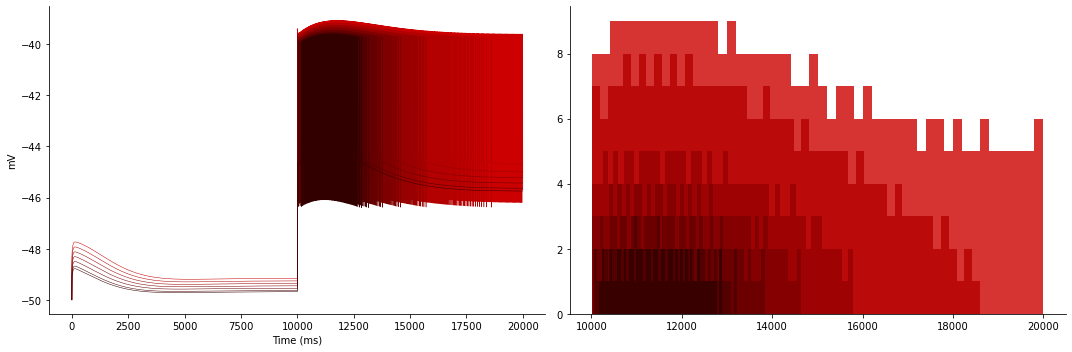

In [8]:
%%time
histFig, histAx = plt.subplots(1,2, figsize=(15,5))
modelIdxOfInt = 4
for miIdx,miVal in enumerate(miAdd):
    c = cmap(cMapping[miIdx])


    params = np.array(valid_sampleResultDf.iloc[modelIdxOfInt].filter(like='bar'))
    gmiMultArray = np.zeros(len(params))
    gmiMultArray[-1] = miVal

    params = params + gmiMultArray

    outputDict = simWrapper(params,fullReturnBool = True)

    v = outputDict['reboundOutput_10']['v']
    t = outputDict['reboundOutput_10']['t']
    pd.DataFrame(v,index=t, columns=['v']).to_csv(reboundHistDir+'/vTrace_gmiAdd_'+str(miAdd[miIdx])+'.csv')
    rebound_params = outputDict['reboundOutput_10']['rebound_params']

    burstTimeThreshold = rebound_params['finalDur']  # Used for burst detection
    burstProminenceThreshold = 0.1
    burstVoltageThreshold = -60
    fList = []
    spikeList = []

    initBool  = rebound_params['initDur']+rebound_params['stepDur'] < t 
    finalBool = rebound_params['initDur']+rebound_params['stepDur'] + rebound_params['finalDur']  > t
    idxOfInt = initBool & finalBool

    burstAnalysisOutput = burstAnalysis(t = t[idxOfInt], v = v[idxOfInt], 
        burstTimeThreshold = burstTimeThreshold, 
        burstVoltageThreshold=burstVoltageThreshold,
        burstProminenceThreshold = burstProminenceThreshold,
        plottingBoolean=False)

    fVal = np.mean(1000/(np.diff(np.array((burstAnalysisOutput['spikesPerBurstTimes'])).flatten())))
    spikeTimes = np.array((burstAnalysisOutput['spikesPerBurstTimes'])).flatten()

    fList.append(fVal)
    spikeList.append(spikeTimes)

    nBins = int(rebound_params['stepDur'] / 200)


    spikeTimes = np.array((burstAnalysisOutput['spikesPerBurstTimes'])).flatten()

    histAx[0].plot(outputDict['reboundOutput_10']['t'],outputDict['reboundOutput_10']['v'], color = c, linewidth=0.5)

    histAx[1].hist(spikeTimes, nBins, alpha = 0.8, color = c)
    
histAx[0].set_ylabel('mV')
histAx[0].set_xlabel('Time (ms)')
plt.tight_layout()
sns.despine()


In [9]:
histFig.savefig(reboundHistDir+'/singleReboundExample_same_gMI_add.pdf')

In [10]:
%%time
miAddList = np.array([0,0.005, 0.014, 0.023, 0.032, 0.041, 0.05 ])#np.linspace(0.005,0.05,6)

miResDict = {}

for miAdd in miAddList:
    miAddVect = np.zeros(len(mechsList))
    miAddVect[-1] = miAdd
    mi_params = np.array(valid_sampleResultDf[mechsList])+miAddVect
    resList = pool.starmap(res_rebound10, tqdm(mi_params,total=len(mi_params)))
    miResDict[str(miAdd)] = resList


CPU times: user 4 s, sys: 803 ms, total: 4.8 s
Wall time: 12min 28s


In [11]:
miDfDict = {}
for key in miResDict:
#     print(key)
    miDfDict[key] = pd.DataFrame(miResDict[key],columns=['a','b','c','lat'])

    

In [12]:
cmap = colors.LinearSegmentedColormap.from_list("", ["black",'red'])

cMapping = np.linspace(0.2,0.8,len(miDfDict))
cMapping

array([0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8])

In [13]:
miDfDict[key]

a         b         c       lat
0    388.642442  5.025583  2.153738  0.028125
1    490.043381  5.218379  2.044677  0.003325
2    338.015708  5.041473  2.243006  0.018925
3    351.666510  5.117982  2.214525  0.026175
4    357.342504  4.127482  1.966244  0.014425
..          ...       ...       ...       ...
193  359.752119  5.012454  2.220374  0.019650
194  403.683706  4.869988  2.159082  0.020375
195  435.931690  5.128990  2.215690  0.018075
196  372.948509  4.978717  2.151525  0.024025
197  417.169912  5.263112  2.229002  0.021300

[198 rows x 4 columns]

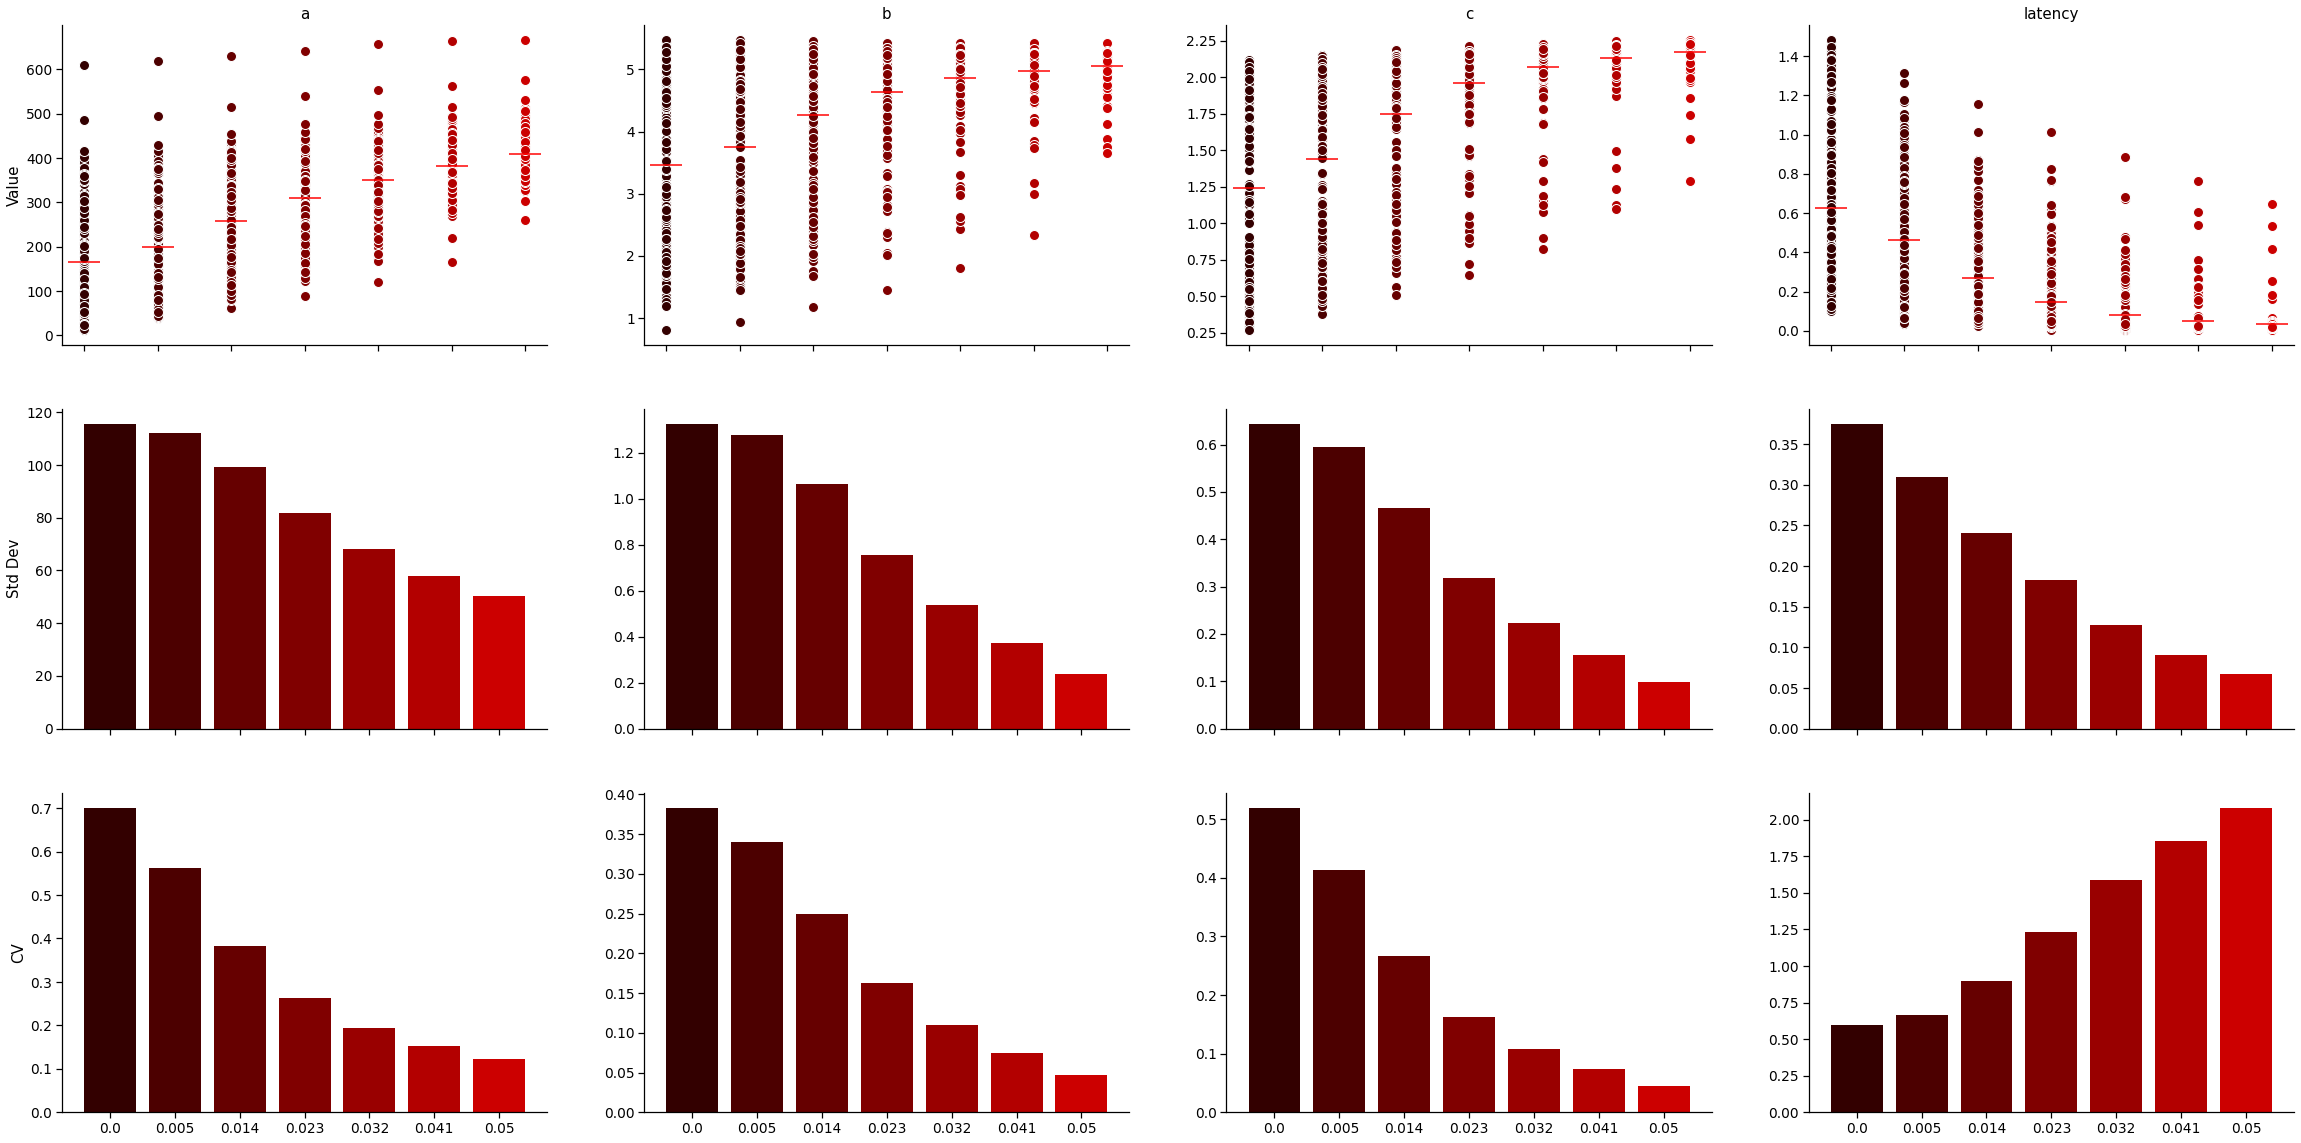

In [14]:
modelKeyList = ['a','b','c','lat']
expKeyList = ['ctrl_a','ctrl_b','ctrl_c','ctrl_lat']
plotKey = ['a','b','c','lat']

sns.set_context("notebook", font_scale=1.25)

varFig,varAxes = plt.subplots(3,len(plotKey), figsize = (40,20))


for attrIdx,_ in enumerate(plotKey):

    for dictIdx,key in enumerate(miDfDict):
        c = cmap(cMapping[dictIdx])
        strKey = key[0:6] #
        varAxes[0,attrIdx].scatter([strKey]*len(np.array(miDfDict[key][modelKeyList[attrIdx]])),
                                   np.array(miDfDict[key][modelKeyList[attrIdx]]), edgecolor='white', color=c, s = 100)
        varAxes[0,attrIdx].scatter(x = strKey, y = miDfDict[key][modelKeyList[attrIdx]].mean(), color='red', marker = '_',s=1000)  
        varAxes[1,attrIdx].bar(x = strKey, height = miDfDict[key][modelKeyList[attrIdx]].std(), color=c)
        varAxes[2,attrIdx].bar(x = strKey, height = miDfDict[key][modelKeyList[attrIdx]].std()/miDfDict[key][modelKeyList[attrIdx]].mean(), color=c)    
    sns.despine()


for rowIdx,_ in enumerate(varAxes):
    for colIdx,_ in enumerate(varAxes[rowIdx]):
        if rowIdx < len(varAxes)-1:
            varAxes[rowIdx,colIdx].set_xticklabels([])
    
varAxes[0,0].set_ylabel('Value')
# varAxes[1,0].set_ylabel('Mean')  
varAxes[1,0].set_ylabel('Std Dev')
varAxes[2,0].set_ylabel('CV')  

varAxes[0,0].set_title('a')
varAxes[0,1].set_title('b')  
varAxes[0,2].set_title('c')
varAxes[0,3].set_title('latency')  


# plt.tight_layout()
varFig.savefig(reboundHistDir+'/reboundHistFits_vals_vars.pdf')

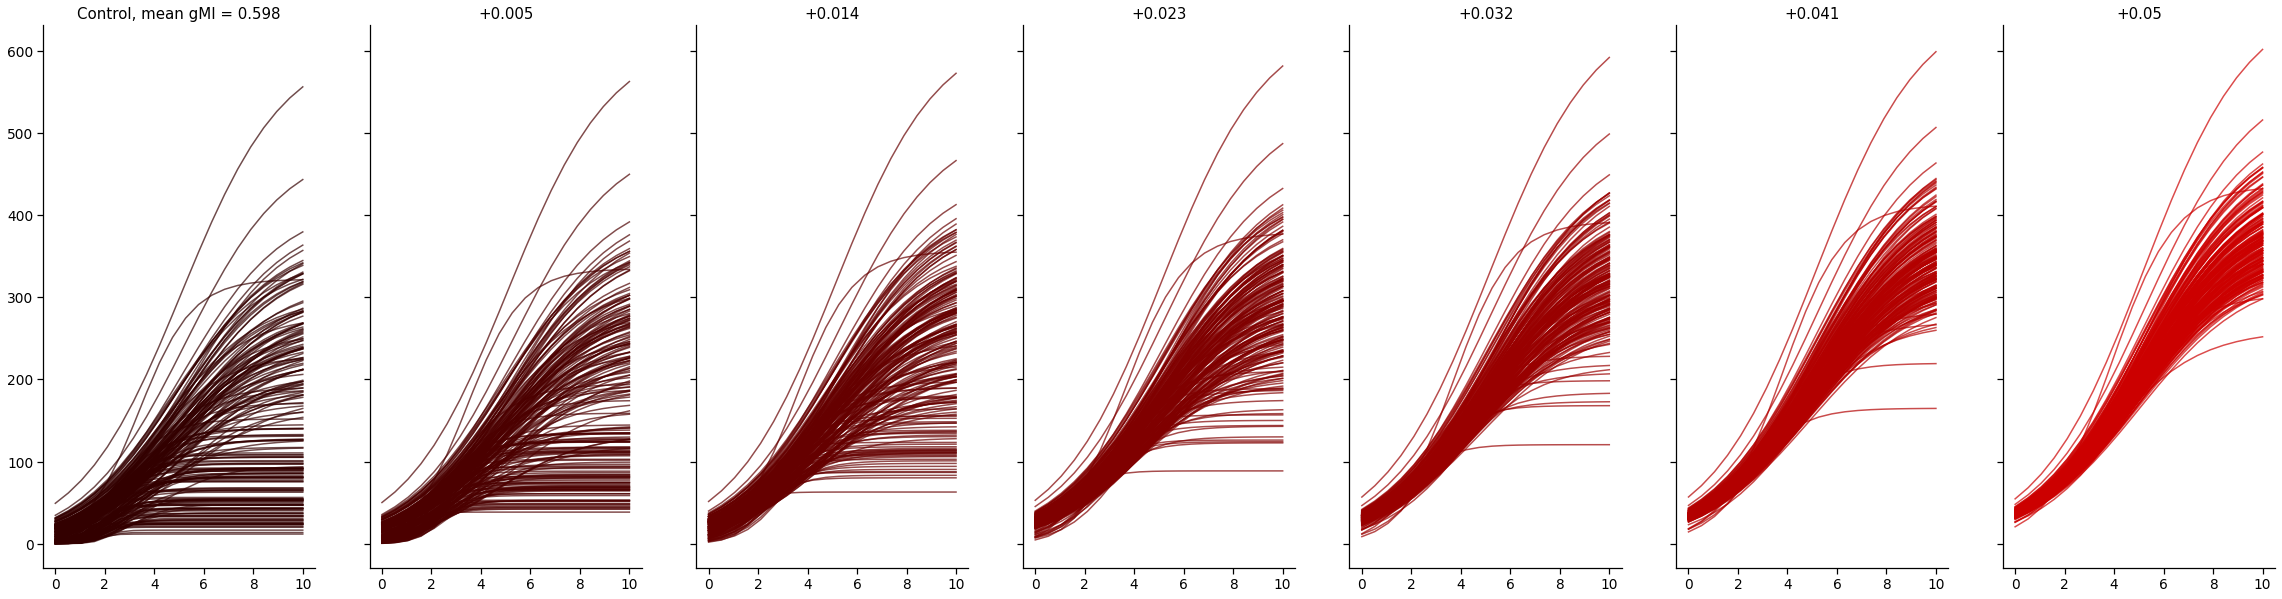

In [15]:
fixed_xdata = np.linspace(0,10,20)

model_cmlHistFig,model_cmlHistAxes = plt.subplots(1,len(miDfDict), figsize=(40,10), sharey = True)


for dictIdx,key in enumerate(miDfDict):
    for modelFitIdx,_ in enumerate(miDfDict[key].index):  
        model_mi_stats = miDfDict[key].iloc[modelFitIdx]

        model_cmlHistAxes[dictIdx].plot(fixed_xdata,ac_sigmoid(x = fixed_xdata,
                            a = model_mi_stats['a'],
                            b = model_mi_stats['b'],
                            c = model_mi_stats['c']),
                            color = cmap(cMapping[dictIdx]), alpha = 0.7)
        
        model_cmlHistAxes[dictIdx].set_title('+'+key[0:5])
        sns.despine()
        

model_cmlHistAxes[0].set_title('Control, mean gMI = '+str(round(valid_sampleResultDf.gbar_mi_soma.mean(),3)))

model_cmlHistFig.savefig(reboundHistDir+'/reboundFits_increasing_gmi_fits.pdf')


In [16]:
valid_sampleResultDf

gbar_leak_soma  gbar_a_soma  gbar_hliu_soma  gbar_kca_soma  Pbar_ca_soma  \
0          1.033845    19.801912       90.439260      41.981040      0.650445   
1          0.283974    20.844687       24.330727      64.871080      0.734384   
2          3.019191     3.240107      179.423510      33.392384      0.271581   
3          2.092200    31.109737      117.284830      38.562572      0.932936   
4          0.526544    10.521814       97.239890      18.234344      0.448832   
..              ...          ...             ...            ...           ...   
193        2.484089     5.213772      156.423900      21.838972      0.824512   
194        1.052046    10.011818       84.797100      17.153120      0.586999   
195        1.429180     7.993391       73.698660      25.413218      0.573827   
196        1.202444    14.558981      110.818960      49.483610      0.523751   
197        2.200155    15.738370       24.198566      32.990005      0.888183   

     gbar_mi_soma  
0        0.535801  
1        0.508265  
2        0.796607  
3        0.892986  
4        0.170215  
..            ...  
193      0.514921  
194      0.277521  
195      0.400496  
196      0.555891  
197      0.705076  

[198 rows x 6 columns]

In [17]:
# reboundHistDir = 'reboundHist_addingMod'
reboundHistFits_baseFileName = reboundHistDir+'/reboundHistFits_adding_mod_'
miDfDict.keys()

for miKey in miDfDict.keys():
    print(reboundHistFits_baseFileName+str(round(eval(miKey),4)))
    miDfDict[miKey].to_csv(reboundHistFits_baseFileName+str(round(eval(miKey),4))+'.csv')

reboundOutput/reboundHistFits_adding_mod_0.0
reboundOutput/reboundHistFits_adding_mod_0.005
reboundOutput/reboundHistFits_adding_mod_0.014
reboundOutput/reboundHistFits_adding_mod_0.023
reboundOutput/reboundHistFits_adding_mod_0.032
reboundOutput/reboundHistFits_adding_mod_0.041
reboundOutput/reboundHistFits_adding_mod_0.05


In [18]:
%%time
miResDict_var = {}
miDistDict_var = {}
# miSTDList = np.linspace(0,0.1,5)
# mi_mean = 0.025

gmiVarValDf = pd.read_csv('reboundData/gMIvals_mean_0p25.csv')
gmiVarValDf.drop(columns='Unnamed: 0',inplace=True)

for key in gmiVarValDf:
    # nVals = len(valid_sampleResultDf)
    mi_dist = np.array(gmiVarValDf[key])
    miDistDict_var[key] = mi_dist
    miAddVect = np.zeros((valid_sampleResultDf[mechsList]).shape) #np.zeros(len(mechsList))
    miAddVect[:,-1] = mi_dist
    mi_params = np.array(valid_sampleResultDf[mechsList])+miAddVect
    resList = pool.starmap(res_rebound10, tqdm(mi_params,total=len(mi_params)))
    miResDict_var[key] = resList



CPU times: user 2.94 s, sys: 643 ms, total: 3.59 s
Wall time: 8min 57s


In [19]:
miDfDict_var = {}
for key in miResDict_var:
    miDfDict_var[key] = pd.DataFrame(miResDict_var[key],columns=['a','b','c','lat'])

In [20]:
miDfDict_var

reboundHistDir_var = 'reboundOutput_addingVariableMod'
reboundHistFits_baseFileName_var = reboundHistDir_var+'/reboundHistFits_adding_variableMod_'
miDfDict_var.keys()

for miKey in miDfDict_var.keys():
    print(reboundHistFits_baseFileName_var+str(round(eval(miKey),4)))
    miDfDict_var[miKey].to_csv(reboundHistFits_baseFileName_var+str(round(eval(miKey),4))+'.csv')


reboundOutput_addingVariableMod/reboundHistFits_adding_variableMod_0.0
reboundOutput_addingVariableMod/reboundHistFits_adding_variableMod_0.025
reboundOutput_addingVariableMod/reboundHistFits_adding_variableMod_0.05
reboundOutput_addingVariableMod/reboundHistFits_adding_variableMod_0.075
reboundOutput_addingVariableMod/reboundHistFits_adding_variableMod_0.1


In [21]:
cmap_var = colors.LinearSegmentedColormap.from_list("", ["red",'orange',"yellow"])
cMapping_var = np.linspace(0.25,0.9,len(miDfDict_var))
cMapping_var

array([0.25  , 0.4125, 0.575 , 0.7375, 0.9   ])

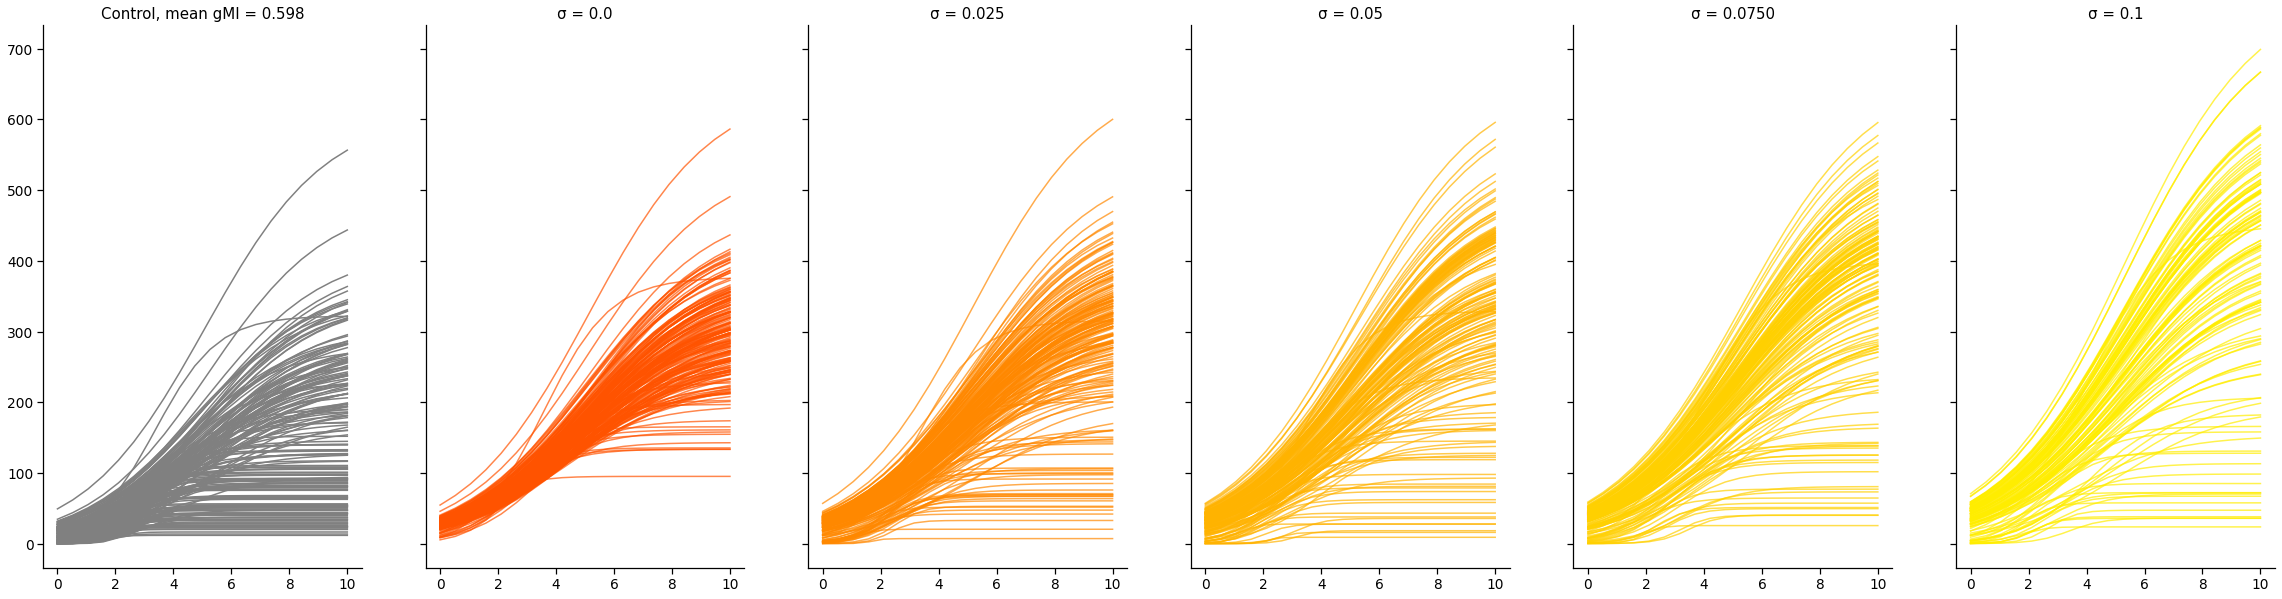

In [22]:
modelKeyList = ['a','b','c','lat']

fixed_xdata = np.linspace(0,10,20)

model_cmlHistFig,model_cmlHistAxes = plt.subplots(1,len(miDfDict_var)+1, figsize=(40,10), sharey = True)
midPlotIdx = 0 
ctrlKey = '0.0'
for modelFitIdx,_ in enumerate(miDfDict[ctrlKey].index):  
    model_stats = miDfDict[ctrlKey].iloc[modelFitIdx]
    model_cmlHistAxes[midPlotIdx].plot(fixed_xdata,ac_sigmoid(x = fixed_xdata,
                        a = model_stats[0],
                        b = model_stats[1],
                        c = model_stats[2]), 
                        color = 'gray')
    model_cmlHistAxes[midPlotIdx].set_title('Control, mean gMI = '+str(round(valid_sampleResultDf.gbar_mi_soma.mean(),3)))

    
for dictIdx,key in enumerate(miDfDict_var):
    for modelFitIdx,_ in enumerate(miDfDict_var[key].index):  
        model_mi_stats = miDfDict_var[key].iloc[modelFitIdx]
        plotIdx = dictIdx
        titleStr = key[0:7]
        
        
        if dictIdx>=midPlotIdx:
            plotIdx = dictIdx+1
            titleStr = key[0:6]
            
        model_cmlHistAxes[plotIdx].plot(fixed_xdata,ac_sigmoid(x = fixed_xdata,
                            a = model_mi_stats['a'],
                            b = model_mi_stats['b'],
                            c = model_mi_stats['c']),
                            color = cmap_var(cMapping_var[dictIdx]), alpha = 0.7)
        
        model_cmlHistAxes[plotIdx].set_title('σ = '+titleStr)
        sns.despine()

model_cmlHistFig.savefig(reboundHistDir_var+'/reboundHistFits_adding_variable_gmi_fits.pdf')    


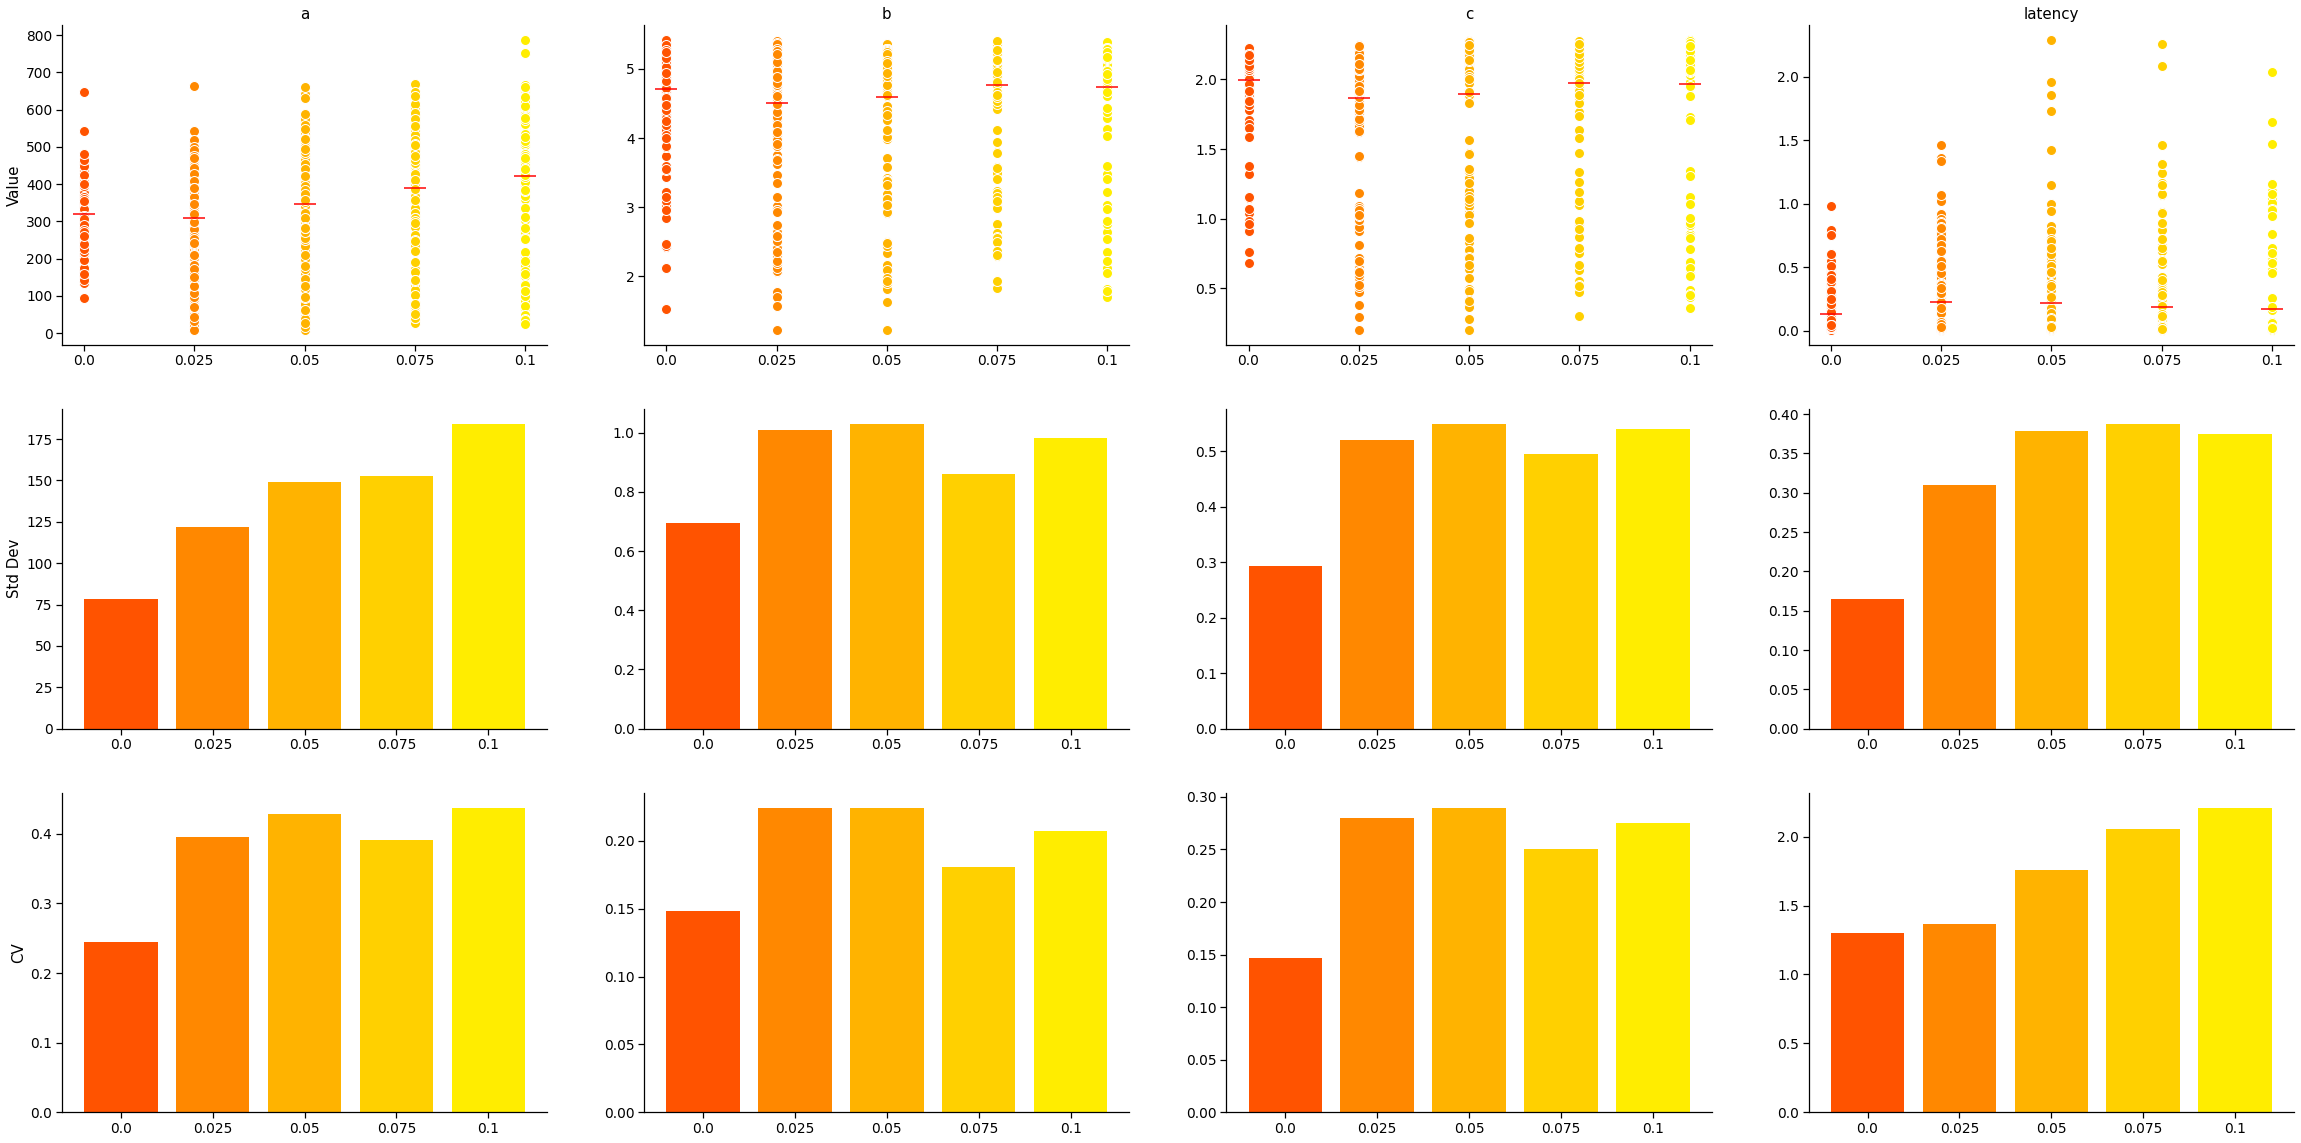

In [23]:
modelKeyList = ['a','b','c','lat']
expKeyList = ['ctrl_a','ctrl_b','ctrl_c','ctrl_lat']
plotKey = ['a','b','c','lat']

varFig,varAxes = plt.subplots(3,len(plotKey), figsize = (40,20))
midPlotIdx = int((len(miDfDict_var)/2))


for attrIdx,_ in enumerate(plotKey):
    
    for dictIdx,key in enumerate(miDfDict_var):
        c = cmap_var(cMapping_var[dictIdx])
        strKey = key[0:5]
        varAxes[0,attrIdx].scatter([strKey]*len(np.array(miDfDict_var[key][modelKeyList[attrIdx]])),
                                   np.array(miDfDict_var[key][modelKeyList[attrIdx]]), edgecolor='white', color=c, s = 100)
        varAxes[0,attrIdx].scatter(x = strKey, y = miDfDict_var[key][modelKeyList[attrIdx]].mean(), color='red', marker='_',s=500)  
        varAxes[1,attrIdx].bar(x = strKey, height = miDfDict_var[key][modelKeyList[attrIdx]].std(), color=[c])
        varAxes[2,attrIdx].bar(x = strKey, height = miDfDict_var[key][modelKeyList[attrIdx]].std()/miDfDict_var[key][modelKeyList[attrIdx]].mean(), color=[c])    
        sns.despine()
    
varAxes[0,0].set_ylabel('Value')
# varAxes[1,0].set_ylabel('Mean')  
varAxes[1,0].set_ylabel('Std Dev')
varAxes[2,0].set_ylabel('CV')  

varAxes[0,0].set_title('a')
varAxes[0,1].set_title('b')  
varAxes[0,2].set_title('c')
varAxes[0,3].set_title('latency')  

varFig.savefig(reboundHistDir_var+'/reboundHistFits_adding_variable_gmi_vals_vars.pdf')    

0.0
0.025
0.05
0.07500000000000001
0.1


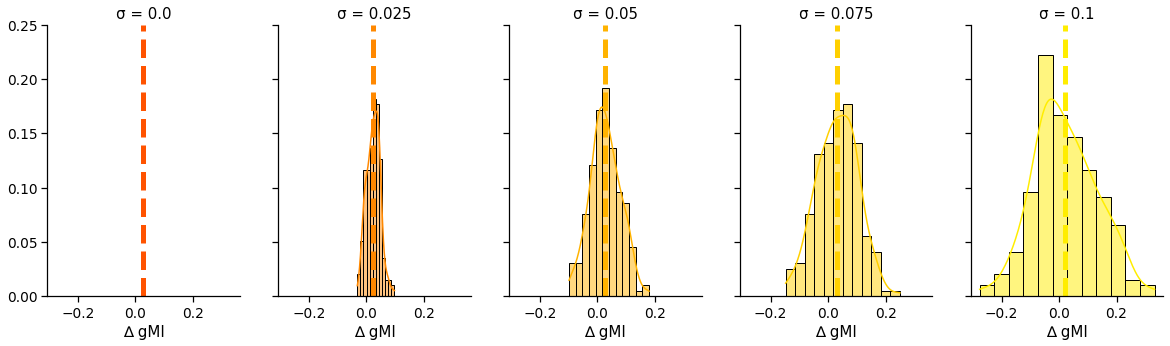

In [24]:
miDistDict_var
distFig, distAxes = plt.subplots(1,len(miDistDict_var), figsize=(20,5),sharex=True, sharey = True)
for keyIdx,key in enumerate(miDistDict_var):
    print(key)
    c = cmap_var(cMapping_var[keyIdx])
    if keyIdx>0:
        sns.histplot(miDistDict_var[key],kde=True,stat='probability',ax=distAxes[keyIdx], color=c)
    distAxes[keyIdx].axvline(np.mean(miDistDict_var[key]),color=c,linestyle='--',linewidth = 5)
    distAxes[keyIdx].set_ylim([0,0.25])
    distAxes[keyIdx].set_xlabel('∆ gMI')
    distAxes[keyIdx].set_title('σ = '+key[0:5])
    
    sns.despine()
distFig.savefig(reboundHistDir_var+'/reboundHistFits_adding_variable_gmi_distributionOfAdded_gmi.pdf')        